![data-x](http://oi64.tinypic.com/o858n4.jpg)


# Image Classification with CNNs

#### Author: Alexander Fred Ojala

**Sources:** 
* **Training + explanations**: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

**Copright:** Feel free to do whatever you want with this code.

---

## Part 1-4: Build your own Cats vs Dogs binary classifier

In this notebook we will implement a binary Cats vs Dogs classifier by removing the top layer of a pretrained network (VGG16 on Imagenet), extracting the features of the training and validation images and then just train the top layer of that network. This way we will be able to make accurate predictions even though we just have a small data set.

We want you to extract the bottleneck features of your images, train the top layer and lastly make predicitons on images not presented to the CNN so far.

The data conists of 2000 training images (1000 cats and 1000 dogs), 800 validation images (400 cats and 400 dogs), and 100 test images (cats and dogs mixed). Find the data here (or in the Github folder): https://www.dropbox.com/s/y2suimh2lt5btam/data.zip?dl=1


The reason why we are using a pretrained network, extracting bottleneck features and training only the top layers is that this is a great way to obtain a high prediction accuracy without having to train from scratch (which takes a long time). it would take up to several days to run this analysis and training your own CNN / DNN on a personal computer (in order to obtain the same level of accuracy).

# Table of Contents

## [Part 1: Install Keras Tensorflow + all dependencies](#sec1)

## [Part 2: Extract bottleneck features from the data set](#sec2)

## [Part 3: Train the top layer of your CNN](#sec3)

## [Part 4: Make predicitons on the mixed test images](#sec4)

# Additional Material

## [TRAIN NETWORK TO CLASSIFY 50 IMAGE CLASSES w/ Theano](#sec5)

## [Train Neural Network from Scratch + Image Augmentation](#sec6)

___

<a id='sec1'></a>

# Part 1: Install Keras + Tensorflow

As a data scientist you will have to be comfortable with installing and setting up your work environment on different systems. Therefore, this first part will be a valuable lesson on how to troubleshoot if you run into problems.

If you want you can also try to use Theano (not supported for future development) as your Keras backend (instead of TensorFlow). Note that there some syntax and dimension handling differences between these two libraries.

Install OpenCV by running: `pip install opencv-python`

# Important set correct backend and image_dim_ordering
**Set tensorflow backend and image_dim_ordering tf**

set it in the **keras.json** file

On mac it is loacted: ``~/.keras/keras.json`` and / or look here https://keras.io/backend/#switching-from-one-backend-to-another

#### For Windows: 
Start up your python-binary and do the following

        import os
        print(os.path.expanduser('~'))
        # >>> C:\\Users\\Sascha'  # will look different for different OS

- This should be the base-directory
- Keras will build a folder .keras there where keras.json resides (if it was already created). If it's not there, create it there
- Example: C:\\Users\\Sascha\\.keras\\keras.json'

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
from keras import backend as K
K.set_image_dim_ordering('tf') # note that we need to have tensorflow dimension ordering still because of the weigths.
print('The backend is:',K.backend())
import tensorflow as tf
print(K.image_dim_ordering()) # should say tf
print(tf.__version__) 

Using TensorFlow backend.


The backend is: tensorflow
tf
1.4.1


In [3]:
# Import relevant packages
import h5py
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#from matplotlib import ticker
#import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, ZeroPadding2D
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import model_from_json
from keras.preprocessing import image

from IPython.display import display

from PIL import Image

# fix random seed for reproducibility
seed = 150
np.random.seed(seed)

In [4]:
# Load in and process data
!ls

catvsdogs_VGG16_pretrained_tf_top.h5
cnns-catsvsdogs-50classes.ipynb
cnn_tensorflow_short.ipynb
data
features_test.npy
features_train.npy
features_validation.npy
intro_to_keras.ipynb
mod_appendix.json
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
w_appendix.h5


In [5]:
# Look at files, note all cat images and dog images are unique
from __future__ import absolute_import, division, print_function 
# make it compatible w Python 2

import os
for path, dirs, files in os.walk('./data'):
    print('FOLDER',path)
    for f in files[:2]:
        print(f)

FOLDER ./data
FOLDER ./data/train
FOLDER ./data/train/dogs
dog0836.jpg
dog0640.jpg
FOLDER ./data/train/cats
cat0950.jpg
cat0258.jpg
FOLDER ./data/validation
FOLDER ./data/validation/dogs
dog001386.jpg
dog001317.jpg
FOLDER ./data/validation/cats
cat001396.jpg
cat001368.jpg
FOLDER ./data/test
FOLDER ./data/test/catvdog
try049.jpg
try005.jpg


In [6]:
print('Number of cat training images:', len(next(os.walk('./data/train/cats'))[2]))
print('Number of dog training images:', len(next(os.walk('./data/train/dogs'))[2]))
print('Number of cat validation images:', len(next(os.walk('./data/validation/cats'))[2]))
print('Number of dog validation images:', len(next(os.walk('./data/validation/dogs'))[2]))
#print('Number of uncategorized test images:', len(next(os.walk('./data/test/catvdog'))[2]))

# There should be 1000 train cat images, 1000 train dogs, 400 validation cats, 400 validation dogs, 100 uncategorized

Number of cat training images: 1000
Number of dog training images: 1000
Number of cat validation images: 400
Number of dog validation images: 400


In [7]:
# Define variables
TRAIN_DIR = './data/train/'
VAL_DIR = './data/validation/'
TEST_DIR = './data/test/' #one mixed category

img_width, img_height = 150, 150

n_train_samples = 2000
n_validation_samples = 800
n_epoch = 30
n_test_samples = 100

<a id='sec2'></a>

# Part 2: Extract bottleneck features from the data set

In the second part you will use the pre-trained VGG network structure (loading in the pretrained VGG16 ImageNET weights). Then you will run your data set through that CNN once to extract the image features.

A good explanation on how this works (rewritten from source: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

#### Using the bottleneck features of a pre-trained network: 90% accuracy in 1 min (GPU) / 10 mins (CPU)

We are leveraging the predictive power of a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

We will use the VGG16 architecture, pre-trained on the ImageNet dataset. Because the ImageNet dataset contains several "cat" classes (persian cat, siamese cat...) and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem. In fact, it is possible that merely recording the softmax predictions of the model over our data rather than the bottleneck features would be enough to solve our dogs vs. cats classification problem extremely well. The method presented here is more likely to generalize well to a broader range of problems, including problems featuring classes absent from ImageNet.

Here's what the VGG16 architecture looks like:

![VGG16](https://blog.keras.io/img/imgclf/vgg16_original.png)


### Horizontal visualization

![https://datatoanalytics.files.wordpress.com/2017/04/vgg161.png](https://datatoanalytics.files.wordpress.com/2017/04/vgg161.png)


**Strategy to extract bottleneck features:** We will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training, validation and test data once, recording the output (the "bottleneck features" from the VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency. Running VGG16 is expensive, especially if you're working on CPU, and we want to only do it once. Note, therefore we will not use data augmentation.

Store the bottleneck features as .npy files.

# This is how the VGG16 net looks in code
You can see the full implementation here of the network we're building and loading in: https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py


```python
    # VGG 16 model architecture
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
```

# IMAGEnet Benchmarks (the Network Structure we're using today won 2014)

![https://qph.ec.quoracdn.net/main-qimg-fbd17e02f01e60b38ff8ee864c647303](https://qph.ec.quoracdn.net/main-qimg-fbd17e02f01e60b38ff8ee864c647303)

In [8]:
# Function for saving bottleneck features
# This can take ~20mins to run

#  Run model once to record the bottleneck features using image data generators:

def save_bottleneck_features():

    from keras import applications
    model = applications.vgg16.VGG16(include_top=False, weights='imagenet', \
                                     input_tensor=None, input_shape=(img_width, img_height,3))
    
    print('TensorFlow VGG16 model architecture loaded')
    
    # include_top = False, because we drop last layer, then we also only need to
    # download weight file that is small, input_shape with channels last
    
    
    # Rescale value, feature scaling, we multiply the data before any other processing. 
    # Our original images consist in RGB coefficients in the 0-255, 
    # but such values would be too high for our models to process (given typical learning rate), 
    # so we target values between 0 and 1 instead by scaling with a 1/255. factor.
    datagen = ImageDataGenerator(rescale=1./255)
    
    def generate_features(DIR,n_samples,name_str):
       
        '''This is a generator that will read pictures found in
        subfolers of 'data/*', and indefinitely generate
        batches of image rescaled images used to predict
        the bottleneck features of the images once
        using model.predict_generator(**args**)'''

        print('Generate '+name_str+' image features')

        generator = datagen.flow_from_directory(
            DIR,
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None, # this means our generator will only yield batches of data, no labels
            shuffle=False) # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
        
        features = model.predict_generator(generator, verbose=1)
        # the predict_generator method returns the output of a model, given
        # a generator that yields batches of numpy data
        
        np.save('features_'+name_str+'.npy', features) # save bottleneck features to file
    
    generate_features(TEST_DIR, n_test_samples, 'test')
    #generate_features(TRAIN_DIR, n_train_samples, 'train')
    #generate_features(VAL_DIR, n_validation_samples, 'validation')
    
    print('\nDone! Bottleneck features have been saved')


print('This has been done before the lecture! Takes 20+ mins to run.')
save_bottleneck_features()

This has been done before the lecture! Takes 20+ mins to run.
TensorFlow VGG16 model architecture loaded
Generate test image features
Found 100 images belonging to 1 classes.


KeyboardInterrupt: 

In [9]:
# Extra
# Obtain class labels and binary classification for validation data
datagen = ImageDataGenerator(rescale=1./255)
val_gen = datagen.flow_from_directory(VAL_DIR,target_size=(img_width, img_height),
                                        batch_size=32,class_mode=None,shuffle=False)

val_labels = val_gen.classes

print('\nClassifications:\n',val_gen.class_indices)
print('\nClass labels:\n',val_labels)

Found 800 images belonging to 2 classes.

Classifications:
 {'cats': 0, 'dogs': 1}

Class labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 

<a id='sec3'></a>

# Part 3: Train the top layer of your CNN

Once you have extracted and written the bottleneck features to files, read them in again and use them to train the top layer of your network, i.e. the small fully-connected model on top of the stored features. When you have done this record and answer with your prediciton accuracy.

**Question:** What is the validation accuracy for the last training epoch, and how is it that we can reach such high accuracy with such small amount of data in a short amount of time?

In [10]:
# Load in bottleneck features
# Run the code below to train your CNN with the training data

def train_model():
    train_data = np.load('features_train.npy')
    # the features were saved in order, so recreating the labels is easy
    train_labels = np.array([0] * (n_train_samples // 2) + [1] * (n_train_samples // 2))

    validation_data = np.load('features_validation.npy')
    # same as val_labels above
    validation_labels = np.array([0] * (n_validation_samples // 2) + [1] * (n_validation_samples // 2))

    # Add top layers trained ontop of extracted VGG features
    # Small fully connected model trained on top of the stored features
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    '''
    #We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. 
    #To go with it we will also use the binary_crossentropy loss to train our model.

    '''
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              nb_epoch=n_epoch, batch_size=32,
              validation_data=(validation_data, validation_labels),shuffle=True) # fit the model

    # Save weights to disk

    # Save model architecture to disk
    model_json = model.to_json()
    with open("mod_appendix.json", "w") as json_file: # save model
        json_file.write(model_json)
    
    # Save model weights
    # save weights
    print("Saved model to disk")
    print('Done!')
    
    return(model)
    
model = train_model()

Train on 2000 samples, validate on 800 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 4.0219 - acc: 0.6100 - val_loss: 0.3151 - val_acc: 0.8638
Epoch 2/30
2000/2000 [==============================] - 2s 969us/step - loss: 0.3814 - acc: 0.8320 - val_loss: 0.3863 - val_acc: 0.8013
Epoch 3/30
2000/2000 [==============================] - 2s 957us/step - loss: 0.3119 - acc: 0.8675 - val_loss: 0.2904 - val_acc: 0.8688
Epoch 4/30
2000/2000 [==============================] - 2s 964us/step - loss: 0.2718 - acc: 0.8900 - val_loss: 0.2436 - val_acc: 0.9075
Epoch 5/30
2000/2000 [==============================] - 2s 982us/step - loss: 0.2287 - acc: 0.9025 - val_loss: 0.2555 - val_acc: 0.8988
Epoch 6/30
2000/2000 [==============================] - 2s 991us/step - loss: 0.1774 - acc: 0.9285 - val_loss: 0.2641 - val_acc: 0.9038
Epoch 7/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1684 - acc: 0.9320 - val_loss: 0.6296 - val_acc: 0.8037
Epoch

<a id='sec4'></a>

# Part 4: Validate accuracy and make predictions on unlabeled data

**Question:** First use the model trained in Part 3 to determine the accuracy on the validation data set (is it the same as one the last training epoch?

Lastly, use the model trained in Part 3 to classify the test data images. I.e., create a function that loads one image from the test data and then predicts if it is a cat or a dog and with what probability it thinks it is a cat or a dog

In [11]:
validation_data = np.load('features_validation.npy')

val_pred_class = model.predict_classes(validation_data,verbose=0) # predict image classes 
val_pred_prob = model.predict_proba(validation_data,verbose=0) # predict image probabilities

print('Accuracy on validation set: ',np.mean(val_pred_class.ravel()==val_labels)*100,'%')

print('\nVal loss & val_acc')
print(model.evaluate(validation_data,val_labels,verbose=0))
# First number is validation loss, loss of the objective function
# Second number validation accuracy

Accuracy on validation set:  91.125 %

Val loss & val_acc
[0.6279841102473438, 0.91125]


In [12]:
# Alternative
print('Model accuracy on validation set:',model.evaluate(validation_data,val_labels,verbose=0)[1]*100,'%')

Model accuracy on validation set: 91.125 %


In [13]:
## Print try images:

# Use the model trained in Problem 1 to classify the test data images.
# Create a function that loads one image from the test data and then predicts
# if it is a cat or a dog and with what probability it thinks it is a cat or a dog
#
# Use variable test_data to make predictions
# Use list test_images to obtain the file name for all images (Note: test_images[0] corresponds to test_data[0])
# Use function plot_pic(img) to plot the image file

## Load in processed images feature to feed into bottleneck model

from PIL import Image

test_data = np.load('features_validation.npy')

test_images =  [VAL_DIR+'cats/'+img for img in os.listdir(VAL_DIR+'cats/')]
test_images = test_images + [VAL_DIR+'dogs/'+img for img in os.listdir(VAL_DIR+'dogs/')]

def read_image(file_path):
    # For image visualization
    im = np.array(Image.open(file_path))
    # img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return im

def plot_pic(img):
    # Plot openCV pic
    pic = read_image(img)    
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.show()

In [14]:
# shuffle cats and dogs
from random import shuffle
shuffle_idx=list(range(800))
shuffle(shuffle_idx)

test_data = test_data[shuffle_idx]

test_images = [test_images[idx] for idx in shuffle_idx]



I think this is a CAT with 100.0% probability


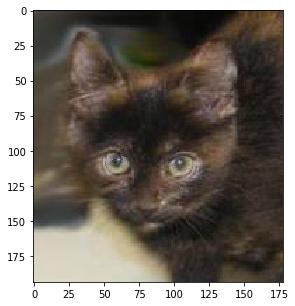



I think this is a DOG with 100.0% probability


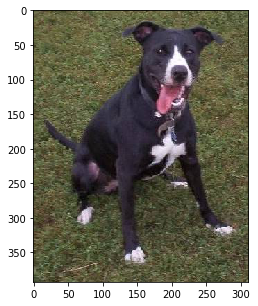



I think this is a DOG with 100.0% probability


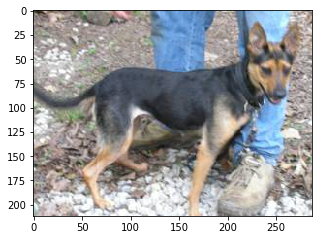



I think this is a DOG with 100.0% probability


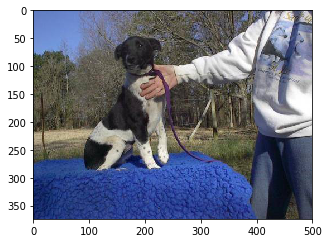



I think this is a CAT with 100.0% probability


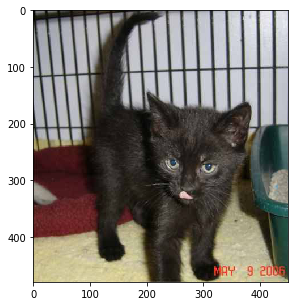



I think this is a CAT with 99.99871% probability


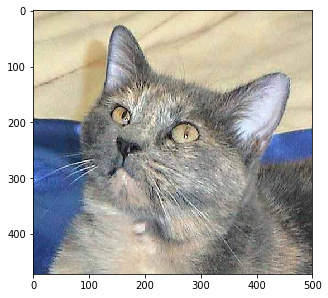



I think this is a CAT with 99.99997% probability


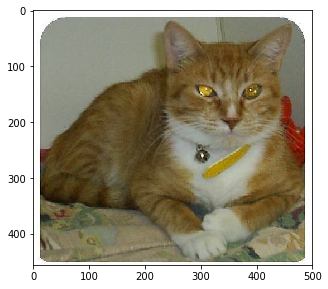



I think this is a CAT with 99.85113% probability


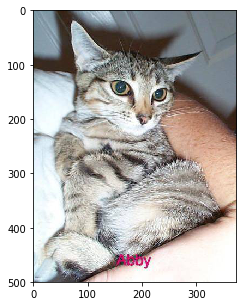



I think this is a CAT with 99.99999% probability


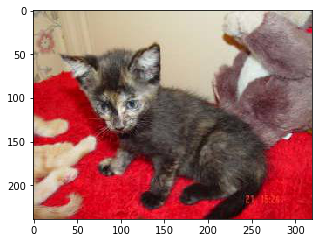



I think this is a CAT with 96.4744% probability


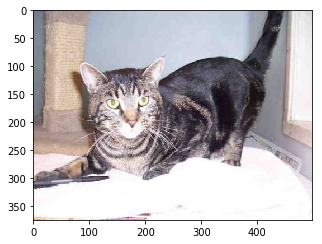



I think this is a DOG with 100.0% probability


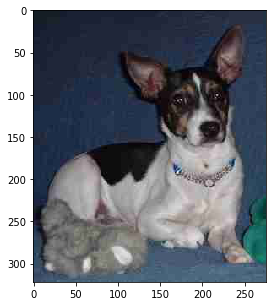



I think this is a DOG with 99.99652% probability


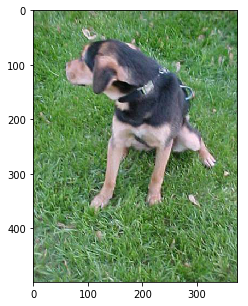



I think this is a CAT with 100.0% probability


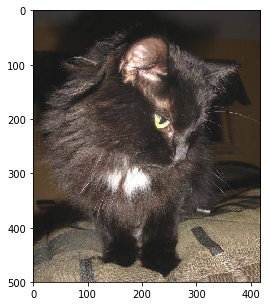



I think this is a DOG with 92.00265% probability


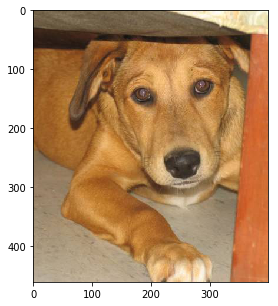



I think this is a CAT with 100.0% probability


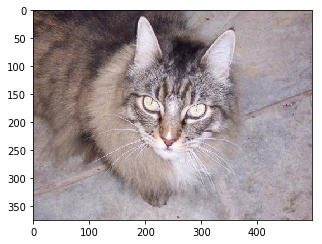



I think this is a CAT with 99.99241% probability


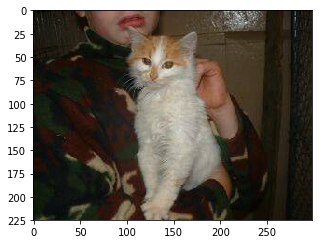



I think this is a CAT with 99.99999% probability


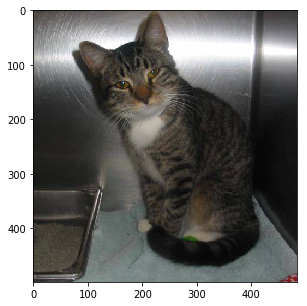



I think this is a DOG with 100.0% probability


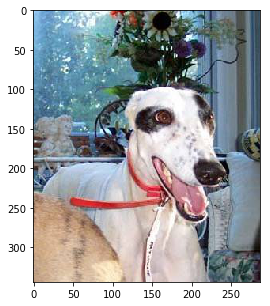



I think this is a CAT with 100.0% probability


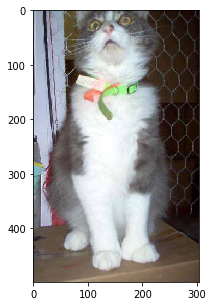



I think this is a DOG with 100.0% probability


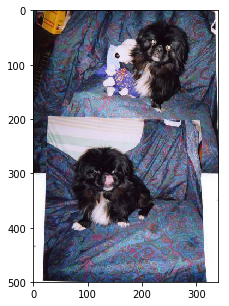

In [15]:
## Answer
import warnings
warnings.filterwarnings('ignore') # filter eventual warning

def predict(mod,i=0,r=None):
    if r==None:
        r=[i]
        
    for idx in r:
        class_pred = mod.predict_classes(test_data,verbose=0)[idx]
        prob_pred = mod.predict_proba(test_data,verbose=0)[idx]
        
        if class_pred ==0:
            prob_pred = 1-prob_pred
            class_guess='CAT'
        else:
            class_guess='DOG'
        
        print('\n\nI think this is a ' + class_guess + ' with ' +str(round(float(prob_pred)*100,5)) + '% probability')
        if test_images[idx]=='./data/test/catvdog/.DS_Store':
            continue
        plot_pic(test_images[idx])

predict(model,r=range(0,20)) # seems to be doing really well

<a id='sec5'></a>

# Part 5 (right now built for Theano):

Redo the model and pipeline created in Part 1-4 in order to make predictions on the 50 image classes. Note that you might have to change how you read in the images, so that when you train the model you do a cross validation split (25 / 75) instead of specifying a specific validation set.  And, you will want to use a `softmax` activation layer instead of a `sigmoid` one (to do multiclass classification).

The data can be downloaded here: https://www.dropbox.com/s/suy8u0hnthwr2su/50_categories.tar.gz?dl=1

Note that you do not have to additional data to make predictions on data not used in the training (however you can easily download 3-5 images like that from Google to try your model).

In [ ]:
# Look at files, note all cat images and dog images are unique
for path, dirs, files in os.walk('./50_categories'):
    print('FOLDER',path)
    for f in files[:2]:
        print(f)

In [ ]:
categories = next(os.walk('./50_categories'))
print(categories)
categories = categories[1]

In [ ]:
# Map categories to an integer
cat_dic = dict()
for idx, cat in enumerate(categories):
    cat_dic[cat] = idx


In [ ]:
print(cat_dic)

In [ ]:
n_imgs = 0
for cat in categories:
    nbr_cat_imgs = len(next(os.walk('./50_categories/'+cat))[2])
    print('Number of '+cat+' images:', nbr_cat_imgs)
    n_imgs+=nbr_cat_imgs

In [ ]:
n_imgs

In [ ]:
from glob import glob
len(glob("./50_categories/*/*.jpg")) #4244 images

In [ ]:
# plot with opencv
img = cv2.imread('./50_categories/airplanes/airplanes_0001.jpg')
img.shape
plt.imshow(img)

In [ ]:
path_all_images = glob("./50_categories/*/*.jpg")
path_all_images[0:10]

In [ ]:
def get_image_categories(images):
    """Get the true categories of a set of paths to images, based on the
    directory they are located in.

    The paths should have the form:
        path/to/image/category/image.jpg

    Where the image filename is the last item in the path, and the
    directory (category name) is the second to last item in the path.

    Parameters
    ----------
    images : list
        List of paths to images

    Returns
    -------
    categories : numpy.ndarray
        An array of integers in order of the images, corresponding to
        each image's category
    category_map : list
        A list of category names. The category integers in
        `categories` are indices into this list.

    """
    get_category = lambda x: os.path.split(os.path.split(x)[0])[1]
    categories = list(map(get_category, images))
    category_map = sorted(set(categories))
    categories = np.array(map(category_map.index, categories))
    return categories, category_map



In [ ]:
img_cats, img_cat_map = get_image_categories(path_all_images)

In [ ]:
img_cat_map[0:3]

In [ ]:
# Define variables
DATA_DIR = './50_categories/'

img_width, img_height = 150, 150

n_samples = n_imgs
n_epoch = 40

In [ ]:
#  Run model once to record the bottleneck features using image data generators:
#  Note: This can take a lot of time

def save_bottleneck_features():

    # build the VGG16 network
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # load the weights of the VGG16 networks
    # note: when there is a complete match between your model definition
    # and your weight savefile, you can simply call model.load_weights(filename)
    assert os.path.exists('vgg16_weights.h5'), 'Model weights not found (Download file vgg16_weights.h5 from bcourses).'
    f = h5py.File('vgg16_weights.h5')
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    f.close()
    print('Model loaded.')

    
    # Rescale value we multiply the data before any other processing. 
    # Our original images consist in RGB coefficients in the 0-255, 
    # but such values would be too high for our models to process (given typical learning rate), 
    # so we target values between 0 and 1 instead by scaling with a 1/255. factor.
    datagen = ImageDataGenerator(rescale=1./255)
    
    def generate_features(DIR,n_samples,name_str):
        '''
        This is a generator that will read pictures found in
        subfolers of 'data/*', and indefinitely generate
        batches of image rescaled images used to predict
        the bottleneck features of the images once
        using model.predict_generator(**args**)
       '''
        print('Generate '+name_str+' image features')

        generator = datagen.flow_from_directory(
            DIR,
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None, # this means our generator will only yield batches of data, no labels
            shuffle=False)  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs

        
        features = model.predict_generator(generator, n_samples)
        # the predict_generator method returns the output of a model, given
        # a generator that yields batches of numpy data
        
        np.save(open('50_classes_features.npy', 'w'), features) # save bottleneck features to file
        
    generate_features(DATA_DIR, n_samples, 'data')


    
save_bottleneck_features()


In [ ]:
# Obtain image labels and binary classification
datagen = ImageDataGenerator(rescale=1./255)
class_gen = datagen.flow_from_directory(DATA_DIR,target_size=(img_width, img_height),
                                        batch_size=32,class_mode=None,shuffle=False)

class_labels = class_gen.classes

print('\nClassifications:\n',class_gen.class_indices)
print('\nClass labels:\n',class_labels)

print(class_gen.class_indices.keys() == cat_dic.keys())

In [ ]:
# since all of our features are stored in order
# and we have not split up our training data into training and validation folders
# in order to not only train on the first classes we need to randomize our samples
# this can easily be done with scikit-learn's test_train_split module

# we train on the X_train and y_train sets
# then we evaluate our model on the X_test and y_test sets

from sklearn.model_selection import train_test_split
class_data = np.load('50_classes_features.npy') # load in bottleneck features
print(class_data.shape)
X_train, X_test, y_train, y_test, path_train, path_test = train_test_split(class_data, class_labels, path_all_images,\
                                                                           test_size=0.2, random_state=150)
print(X_train.shape)

In [ ]:
print(path_train[0:4])
print([img_cat_map[i] for i in y_train[0:4]]) # the img_paths have been mapped correctly

In [ ]:
# Load in bottleneck features
# Run the code below to train your CNN with the training data
from keras.optimizers import SGD



# the features were saved in order, so recreating the labels is easy


# Add top layers trained ontop of extracted VGG features
# Small fully connected model trained on top of the stored features
model = Sequential()
model.add(Flatten(input_shape=class_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='softmax'))
#model.add(Dense(4096, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(4096, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(50, activation='softmax'))

    
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=32, nb_epoch=40,validation_split=0, verbose=1) # we don't need a validation split
print('Done!')

In [ ]:

val_pred_class = model.predict_classes(X_test,verbose=1)
#val_pred_prob = model.predict_proba(class_data,verbose=0)

print(model.evaluate(X_test,y_test,verbose=0))
# First number is validation loss, loss of the objective function
# Second number validation accuracy

In [ ]:
print(np.unique(val_pred_class)) #ok 50 classes in our prediction

In [ ]:
np.sum(val_pred_class==y_test)/len(y_test) # ~60% accuracy

In [ ]:
print(model.evaluate(X_test,y_test,verbose=0))

In [ ]:
print(DATA_DIR)

In [ ]:
def read_image(file_path):
    # For image visualization
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    #return cv2.resize(img, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
    return img

def plot_pic(img):
    # Plot openCV pic
    pic = read_image(img)    
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.show()

In [ ]:
#alternative plotpic function
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_pic(img):
    image = mpimg.imread(img)
    plt.figure(figsize=(9,9))
    plt.imshow(image)
    plt.grid(False)
    plt.show()

In [ ]:
def predict(mod,i=0,r=None):
    preds = mod.predict_classes(X_test,verbose=0)
    
    if r==None:
        r=[i]
        
    for idx in r:
        
        img_path = path_test[idx]
        img = image.load_img(img_path, target_size=(150, 150))
        #x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        class_pred = preds[idx]
        
        class_guess = img_cat_map[class_pred]
        
        print('\n\nProbable category: ' + class_guess)
        plot_pic(path_test[idx])

predict(model,r=range(0,100))

# As we can see below it is pretty accurate, however, for the case when we don't have many 
# training samples the accuracy is not as good.

<a id='sec6'></a>
# Appendix: Training a small convnet from scratch: 80% accuracy in 40 lines of code

The right tool for an image classification job is a convnet, so let's try to train one on our data, as an initial baseline. Since we only have few examples, our number one concern should be overfitting. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three, images of people who are sailors, and among them only one lumberjack wears a cap, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Data augmentation is one way to fight overfitting, but it isn't enough since our augmented samples are still highly correlated. Your main focus for fighting overfitting should be the entropic capacity of your model --how much information your model is allowed to store. A model that can store a lot of information has the potential to be more accurate by leveraging more features, but it is also more at risk to start storing irrelevant features. Meanwhile, a model that can only store a few features will have to focus on the most significant features found in the data, and these are more likely to be truly relevant and to generalize better.

There are different ways to modulate entropic capacity. The main one is the choice of the number of parameters in your model, i.e. the number of layers and the size of each layer. Another way is the use of weight regularization, such as L1 or L2 regularization, which consists in forcing model weights to taker smaller values.

In our case we will use a very small convnet with few layers and few filters per layer, alongside data augmentation and dropout. Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in your data).

The code snippet below is our first model, a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun advocated in the 1990s for image classification (with the exception of ReLU).

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows you to:

configure random transformations and normalization operations to be done on your image data during training
instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

In [ ]:
# Import image data generator

datagen = ImageDataGenerator(
        rotation_range=40, #rotation_range degrees (0-180), range that randomly rotate pictures
        width_shift_range=0.2, #width_shift range (fraction of total width) within which to randomly translate pic
        height_shift_range=0.2, # -ii-
        
        #rescale value we multiply the data before any other processing. 
        #Our original images consist in RGB coefficients in the 0-255, 
        #but such values would be too high for our models to process (given typical learning rate), 
        # so we target values between 0 and 1 instead by scaling with a 1/255. factor.
        rescale=1./255,
        
        #randomly applying shearing transformations (shear mapping is a linear map that 
        #displaces each point in fixed direction, by an amount proportional to its 
        #signed distance from a line that is parallel to that direction)
        shear_range=0.2, 
        zoom_range=0.2, #randomly zooming inside pictures
        
        #is for randomly flipping half of the images horizontally 
        #--relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).

        horizontal_flip=True,
    
        #is the strategy used for filling in newly created pixels, 
        #which can appear after a rotation or a width/height shift.
        fill_mode='nearest')

Now let's start generating some pictures using this tool and save them to a temporary directory, so we can get a feel for what our augmentation strategy is doing --we disable rescaling in this case to keep the images displayable:

In [ ]:
img = load_img(TRAIN_DIR+'cats/cat0001.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0

from PIL import Image


if not os.path.exists('preview'):
    os.makedirs('preview')

for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

prev_files = next(os.walk('./preview'))[2]
print(prev_files[:4])

def read_image(file_path):
    # For image visualization
    im = np.array(Image.open(file_path))
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return im

def plot_pic(img):
    # Plot openCV pic
    pic = read_image(img)    
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.show()


for img in prev_files[:4]:
    print('Image '+img)
    plot_pic('./preview/'+img)

In [ ]:
def first_model():

    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=(img_height, img_width, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    '''
    On top of it we stick two fully-connected layers. 
    We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. 
    To go with it we will also use the binary_crossentropy loss to train our model.
    '''

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    
    # Let's prepare our data. We will use .flow_from_directory()
    # to generate batches of image data (and their labels) directly from our jpgs in their respective folders.
    
    # Below is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    print('Train generator')
    train_generator = train_datagen.flow_from_directory(
            TRAIN_DIR,  # this is the target directory
            target_size=(img_height, img_width),  # all images will be resized to 150x150
            batch_size=32,
            class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

    # this is a similar generator, for validation data
    print('Validation generator')
    validation_generator = test_datagen.flow_from_directory(
            VAL_DIR,
            target_size=(img_height, img_width),
            batch_size=32,
            class_mode='binary')
    

    
    return model, train_generator, validation_generator

In [ ]:
# Look at class indices from our generators


_, train_gen,val_gen =first_model()
print('')
print(val_gen.class_indices)
print(val_gen.classes)

In [ ]:
# Define and fit the first model
n_epoch = 50 # should be around 50 epochs for 80% accuracy
def fit_first_model():

    mod1, train_generator, validation_generator = first_model()
    mod1.fit_generator(
            train_generator,
            samples_per_epoch=n_train_samples,
            nb_epoch=n_epoch,
            validation_data=validation_generator,
            nb_val_samples=n_validation_samples)

    # save model to disk
    mod1.save_weights('w_appendix.h5')  # always save your weights after training or during training
    model_json = mod1.to_json()
    with open("mod_appendix.json", "w") as json_file:
        json_file.write(model_json)
    print("Saved model to disk")

#fit_first_model()
print('This has already been run!')

### DONE ###

In [ ]:
# FIRST MODEL EXPLORATION

# load model 1 and weights

json_file = open('mod_appendix.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
mod1 = model_from_json(loaded_model_json)
# load weights into new model
mod1.load_weights("w_appendix.h5")
print("Loaded model from disk")

mod1.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

# Extract image features from test set - to make predictions

datagen = ImageDataGenerator(rescale=1./255)

# this is a similar generator, for validation data
val_generator = datagen.flow_from_directory( VAL_DIR, target_size=(img_height, img_width),
                                              batch_size=32,class_mode='binary')

preds = mod1.evaluate_generator(val_generator,n_validation_samples)

print('\nModel 1 accuracy on 800 validation images:', round(sum(preds)/2,4)*100,'%')

In [ ]:
# Plot picture and print class prediction on cats vs dogs (unsorted)


try_images =  [TEST_DIR+'catvdog/'+img for img in os.listdir(TEST_DIR+'catvdog/')]

def predict(mod,i=0,r=None):
    if r==None:
        r=[i]
        
    for idx in r:
        if 'DS_Store' in try_images[idx]:
            continue
        
        img_path = try_images[idx]
        img = image.load_img(img_path, target_size=(150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        class_pred = mod.predict_classes(x,verbose=0)
        
        if class_pred == 0:
            class_guess='CAT'
        else:
            class_guess='DOG'
        
        print('\n\nI think this is a ' + class_guess)
        plot_pic(try_images[idx])

predict(mod1,r=range(len(try_images)-64))